# Анализ тональности текста новостей

In [ ]:
!git clone https://github.com/Samsung-IT-Academy/stepik-dl-nlp.git && pip install -r stepik-dl-nlp/requirements.txt
import sys; sys.path.append('./stepik-dl-nlp')

In [ ]:
!pip install deeppavlov
!pip install -U scikit-learn

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk import word_tokenize, sent_tokenize
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from collections import defaultdict
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import json

from dlnlputils.data import tokenize_text_simple_regex, tokenize_corpus

from __future__ import division
from collections import Counter
import numba as nb
import re, nltk

import os

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Загрузка данных

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# тут Требуется считать файл train
# with open('/content/drive/MyDrive/data/train.json', encoding="utf-8") as f:
#     raw_data = json.load(f)

In [ ]:
texts, sents = [raw['text'] for raw in raw_data], [raw['sentiment'] for raw in raw_data]
raw_df = pd.DataFrame.from_dict({'text': texts, 'sentiment': sents})


In [ ]:
# !conda update --force-reinstall pandas
# pd.set_option('display.max_colwidth', -1)
raw_df.head

<bound method NDFrame.head of                                                    text sentiment
0     Досудебное расследование по факту покупки ЕНПФ...  negative
1     Медики рассказали о состоянии пострадавшего му...  negative
2     Прошел почти год, как железнодорожным оператор...  negative
3     По итогам 12 месяцев 2016 года на территории р...  negative
4     Астана. 21 ноября. Kazakhstan Today - Агентств...  negative
...                                                 ...       ...
8258  Как мы писали еще весной, для увеличения сбыта...  positive
8259  Но молодой министр национальной экономики Биши...  negative
8260  \n \nВ ЕНПФ назначен новый председатель правле...   neutral
8261  В Алматы у отделения банка произошло нападение...  negative
8262  НПП РК «Атамекен» предлагает создать Националь...   neutral

[8263 rows x 2 columns]>

## Биграммы и Юниграммы + графики. Синтаксические связи

In [ ]:
train_tokenized = tokenize_corpus(texts)

# train_tokenized[:1]

In [ ]:
import nltk 
from nltk import FreqDist                # Частотный словарь
nltk.download('punkt')                      # Модуль с пунктуацией
from nltk.tokenize import word_tokenize     # Пространство токенизатора

tokens_word = word_tokenize('\n'.join(list(map(lambda i : ' '.join(i),train_tokenized))))

tokens_word[:10]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['досудебное',
 'расследование',
 'факту',
 'покупки',
 'енпф',
 'пакета',
 'облигаций',
 'бузгул',
 'аурум',
 'было']

In [ ]:
unigram = list(nltk.ngrams(tokens_word, 1))   # Выделение токенов в качестве кортежей
bigram = list(nltk.ngrams(tokens_word, 2))    # Выделение биграмм в список кортежей   
print(unigram[:5])  # Первые 5 токенов
print(bigram[:5])   # Первые 5 биграмм

[('досудебное',), ('расследование',), ('факту',), ('покупки',), ('енпф',)]
[('досудебное', 'расследование'), ('расследование', 'факту'), ('факту', 'покупки'), ('покупки', 'енпф'), ('енпф', 'пакета')]


In [ ]:
unigram_out =  FreqDist(unigram)
bigram_out = FreqDist(bigram)
print('Популярные униграммы: ', FreqDist(unigram).most_common(5))   # подсчёт популярности кортежей из токенов
print('Популярные биграммы: ', FreqDist(bigram).most_common(5))

Популярные униграммы:  [(('года',), 22805), (('тенге',), 15684), (('году',), 11221), (('также',), 10948), (('казахстана',), 10685)]
Популярные биграммы:  [(('республики', 'казахстан'), 5831), (('2016', 'года'), 5291), (('млрд', 'тенге'), 5092), (('2015', 'года'), 2143), (('кроме', 'того'), 2065)]


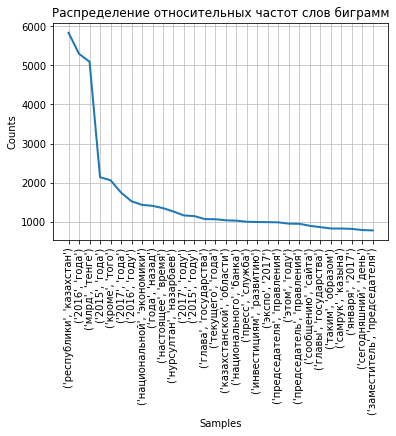

In [ ]:
bigram_out.plot(30,cumulative=False,title ='Распределение относительных частот слов биграмм')

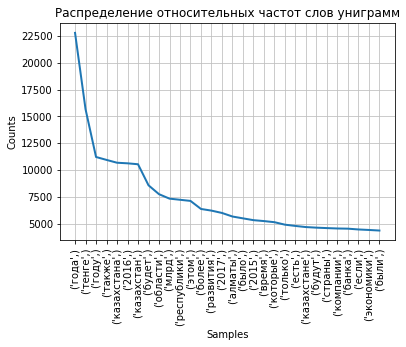

In [ ]:
unigram_out.plot(30,cumulative=False,title ='Распределение относительных частот слов униграмм')

##Применяем Биграммы и униграммы. Строим нужный формат для работы


In [ ]:
# еще раз считываем, потому что немного другой формат будет. Потом можно исправить
with open('/content/drive/MyDrive/data/train.json' , encoding="utf-8") as f:
    train_source = json.load(f)
    train_data = []
    train_data_sent_lb = []
    for i in range(0 , len(train_source)) :
      train_tokenized = train_source[i]['text']
      label_train = train_source[i]['sentiment']
      train_data.append(train_tokenized)
      train_data_sent_lb.append(label_train)

In [ ]:

!conda update --force-reinstall pandas
pd.set_option('display.max_colwidth', -1)
data = pd.DataFrame( list(zip(train_data, train_data_sent_lb)), columns= ['News','sentiment'])
data

/bin/bash: conda: command not found


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  This is separate from the ipykernel package so we can avoid doing imports until


ImportError: ignored

In [ ]:
def make_training_test_sets(data):
    
    data_shuffled = data.iloc[np.random.permutation(len(data))]
    data_shuffled = data_shuffled.reset_index(drop=True)
    
    data_shuffled.News = data_shuffled.News.apply(lambda tweet: "".join(tweet))
    
    positive_data = data_shuffled[data_shuffled.sentiment == 'positive']
    negative_data = data_shuffled[data_shuffled.sentiment == 'negative']

    
    positive_data_cutoff = int(len(positive_data) * (3./4.))
    negative_data_cutoff = int(len(negative_data) * (3./4.))

    
    training_data = pd.concat([positive_data[:positive_data_cutoff], negative_data[:negative_data_cutoff]])
    test_data = pd.concat([positive_data[positive_data_cutoff:], negative_data[negative_data_cutoff:]])

    
    training_data = training_data.iloc[np.random.permutation(len(training_data))].reset_index(drop=True)
    test_data = test_data.iloc[np.random.permutation(len(test_data))].reset_index(drop=True)
    
    return training_data, test_data

training_data, test_data = make_training_test_sets(data)

print ("size of training set: " + str(len(training_data)))
print ("size of test set: " + str(len(test_data)))

size of training set: 3171
size of test set: 1058


In [ ]:
from sklearn.model_selection import KFold
# from sklearn.cross_validation import KFold - depricated
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import preprocessing
import re


In [ ]:

def classify(training_data, test_data, ngram=(1, 1)):
    
    scores = []

    k_fold = KFold(n_splits=10)

    
    count_vectorizer = CountVectorizer(ngram_range=ngram)

    training_data.sentiment = training_data.sentiment.replace('negative',0)
    training_data.sentiment = training_data.sentiment.replace('positive',1)

    confusion = np.array([[0, 0], [0, 0]])

    for training_indices, validation_indices in k_fold.split(training_data):

        training_features = count_vectorizer.fit_transform(training_data.iloc[training_indices]['News'])
        training_labels = training_data.iloc[training_indices]['sentiment'].values

        validation_features = count_vectorizer.transform(training_data.iloc[validation_indices]['News'].values)

        validation_labels = training_data.iloc[validation_indices]['sentiment'].values

        classifier = MultinomialNB()
        classifier.fit(training_features, training_labels)
        validation_predictions = classifier.predict(validation_features)

        confusion += confusion_matrix(validation_labels, validation_predictions)


        score = f1_score(validation_labels, validation_predictions)
        scores.append(score)
    
    return (sum(scores) / len(scores)), confusion

score, confusion = classify(training_data, test_data)

print ('Total classified: ', len(training_data))
print ( 'Score: ',score)
print ('Confusion matrix:')
print(confusion)

Total classified:  3171
Score:  0.9222334985668847
Confusion matrix:
[[ 922  153]
 [ 171 1925]]


In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt

In [ ]:
labels = ['Positive', 'Negative']
def plot_confusion_matrix(cm, labels, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
print ('Confusion matrix without normalization')
plt.figure()
 

Confusion matrix without normalization


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

## Применяем биграммы

Total classified:  3171
Score:  0.9338233619613684
Confusion matrix:
[[ 902  173]
 [ 108 1988]]


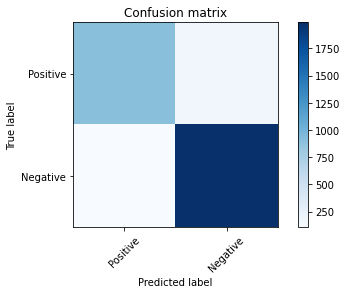

In [ ]:

score, confusion = classify(training_data, test_data, (1, 1))

print ('Total classified: ' ,len(training_data))
print ('Score: ' ,  score)
print ('Confusion matrix:')
print(confusion)

plot_confusion_matrix(confusion, labels)

## Препроцессинг текста


Минус Эмоджи (кто знает, а вдруг)

In [ ]:
# избавляемся от эможди
emoji_pattern = re.compile("["
                u"\U0001F600-\U0001F64F"  # emoticons
                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                u"\U0001F1E0-\U0001F1FF"  
                u"\U00002702-\U000027B0"
                u"\U000024C2-\U0001F251"
                u"\U0001f926-\U0001f937"
                u'\U00010000-\U0010ffff'
                u"\u200d"
                u"\u2640-\u2642"
                u"\u2600-\u2B55"
                u"\u23cf"
                u"\u23e9"
                u"\u231a"
                u"\u3030"
                u"\ufe0f"
    "]+", flags=re.UNICODE)

def remove_emoji(string):
    return emoji_pattern.sub(r'', string)

In [ ]:
#токенизируем
def no_emoji_tokenize(string):
  words = word_tokenize(string)
  return map(remove_emoji, words)
  
def ru_token(string):
    """russian tokenize based on nltk.word_tokenize. only russian letter remaind."""
    return [i.lower() for i in no_emoji_tokenize(string) if re.match(r'[\u0400-\u04ffа́]+$', i)]

In [ ]:
data_df = raw_df.copy()
data_df['text'] = raw_df['text'].apply(ru_token)

Посмотрим на текущий вид данных

In [ ]:
data_df.head(10)

ImportError: ignored

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 text sentiment
0  [досудебное, расследо

### Разделение слипшихся слов.



Мы будем использовать частотный словарь русского корпуса.
Будем проходить по словам в данных. Если находим слово, которое не существует в словаре, будем делить его на части полным перебором. При каждом разделении вычисляем ве
яроятность того, что данное разделение возможно, основываясь на частотных вероятностях полученных частей слова. В итоге выбираем разделение наиболее вероятное.

Для ускорения процесса будем кешировать данные.

Скачиваем корпус русского языка


In [ ]:
if not os.path.isfile('./corpus/1grams-3.txt'):
  if not os.path.exists('./corpus'):
    os.makedirs('./corpus')
  print("Скачивание архива с файлом, содержащим частоты словоформ.")
  import urllib.request
  import zipfile
  url = 'http://www.ruscorpora.ru/ngrams/1grams-3.zip'  
  urllib.request.urlretrieve(url, './corpus/1grams-3.zip')
  with zipfile.ZipFile('./corpus/1grams-3.zip','r') as zip_ref:
    zip_ref.extractall('./corpus/')
  os.remove('./corpus/1grams-3.zip')
  print("Скачивание окончено.")
  

Скачивание архива с файлом, содержащим частоты словоформ.
Скачивание окончено.


In [ ]:
def get_corpus_dict():
  dic = dict()
  with open('corpus/1grams-3.txt') as f:
    for line in f.readlines():
      freq, word = line.strip().split("\t")
      dic[word] = int(freq)

  return dic

In [ ]:
corpus_dict = get_corpus_dict()
print("Количество слов в корпусе:", len(corpus_dict))

Количество слов в корпусе: 1054210


In [ ]:
def print_dict(dic, n=5):
  i = 0
  print("word -- key")
  for k, v in dic.items():
    if i == n:
      break
    print(k, "--", v)
    i += 1

In [ ]:
print_dict(corpus_dict)

word -- key
и -- 6829968
в -- 5190215
не -- 3164900
на -- 2729210
с -- 2064408


Как вы можем видеть сверху, у каждого слова есть значение частоты. Однако, нам нужно превести это в вероятностную величину в рамках [0, 1]. 

Однако не все так глядко. Сумма частот оказалась слишком большой, поэтому будем использовать иной метод нормализации частоты для получения вероятности.

Так мы будем нормализовать частоты, деля на максимальное значение в словаре, то есть на значение слова "и" = 6829968

In [ ]:
FREQ_MAX = max(corpus_dict.values())
FREQ_MAX

6829968

Функция нормализации

In [ ]:
freq_normalize = lambda x: x / FREQ_MAX

Нормализуем данные

In [ ]:
corpus_dict = {k: freq_normalize(v) for k, v in corpus_dict.items()}

In [ ]:
print_dict(corpus_dict)

word -- key
и -- 1.0
в -- 0.7599179088393972
не -- 0.46338430868197333
на -- 0.39959338023252816
с -- 0.3022573458616497


Огонь фича! Используем функцию враппер для кеширования аргументов для ускорения.

In [ ]:
def memo(f):
    "Memoize function f, whose args must all be hashable."
    cache = {}
    def fmemo(*args):
        if args not in cache:
            cache[args] = f(*args)
        return cache[args]
    fmemo.cache = cache
    return fmemo

Функционал для сегметации слов на части на основе частотных вероятностей.

In [ ]:
def pdist(word):
    "Make a probability distribution, given evidence from a Counter."
    if word in corpus_dict:
      return corpus_dict[word]
    else:
      return 0

def Pwords(words):
    "Probability of words, assuming each word is independent of others."
    return np.prod([pdist(w) for w in words])

def splits(text, start=0, L=20):
    "Return a list of all (first, rest) pairs; start <= len(first) <= L."
    return [(text[:i], text[i:]) 
            for i in range(start, min(len(text), L)+1)]

@memo
def segment(text):
    "Return a list of words that is the most probable segmentation of text."
    if not text: 
        return []
    else:
      candidates = ([first] + segment(rest) 
                    for (first, rest) in splits(text, 1))
      return max(candidates, key=Pwords)

Протестируем сегментацию

In [ ]:
%time print(segment('приветмир'))

['привет', 'мир']
CPU times: user 1.69 ms, sys: 0 ns, total: 1.69 ms
Wall time: 1.68 ms


Функция для сегментирования слов в данных. Важный момент: после, стоит очистить данные от слов длиной меньше 3 букв, ибо они врядли будут нести смысл в текст и считаются скорее как stop words. Хоть очистка от stop words будет еще применена в дальнейшем, дополнительная очистка не помешает.

In [ ]:
def segment_words(words):
  new_words = []
  for word in words:
    if word in corpus_dict:
      new_words.append(word)
    else:
      new_words.extend(segment(word))
  new_words = list(filter(lambda w: len(w)>2, new_words))
  return new_words

In [ ]:
data_df['text'] = data_df['text'].apply(segment_words)

Поглядим на получившиеся данные.

In [ ]:
data_df.head

<bound method NDFrame.head of                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

### Лемматизация.

Как уже было сказано, лемматизация важна для сокращения словаря наших данных. Более того, она снижает смысловую нагрузку, упрощая и стандартизируя слова.


Для данной цели, будем использовать токенайзер с лемматизацией русского языка от DeepPavlov.

In [ ]:
from deeppavlov.models.tokenizers.ru_tokenizer import RussianTokenizer
rus_tokenizer = RussianTokenizer(lemmas=True, stopwords=stopwords.words('russian'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package perluniprops to /root/nltk_data...
[nltk_data]   Unzipping misc/perluniprops.zip.
[nltk_data] Downloading package nonbreaking_prefixes to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping corpora/nonbreaking_prefixes.zip.


Функция полной токенизации, основанной на всем, что мы сделали до этого.

In [ ]:
def final_tokenizer(string):
  words = segment_words(ru_token(string))
  return rus_tokenizer([" ".join(words)])[0]

## Создадим TF-IDF векторизатор
Будем использовать векторизированные данные для обучения моделей.

In [ ]:
params = {}
params['tokenizer'] = final_tokenizer
params['stop_words'] = stopwords.words('russian')
params['ngram_range'] = (1, 3)
params['min_df'] = 3


In [ ]:
tfidf  = TfidfVectorizer(**params)

In [ ]:
tfidf.fit([i for i in raw_df['text']])

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


TfidfVectorizer(min_df=3, ngram_range=(1, 3),
                stop_words=['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с',
                            'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его',
                            'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы',
                            'по', 'только', 'ее', 'мне', ...],
                tokenizer=<function final_tokenizer at 0x7fc1bc5a5170>)

## Разделим данные на обучающие и тестовые выборки.
Разделение будем проводить честно: делим данные отдельно по каждому виду тональности.

In [ ]:
train = {}
test = {}
tmp = defaultdict(list)
for _, row in raw_df.iterrows():
    tmp[row['sentiment']].append(row['text'])
for l in tmp:
    train[l], test[l] = train_test_split(tmp[l], test_size=0.2, random_state=2019)

Также, проводим выравнивание количества данных по каждому классу тональности в обучающей выборке.

In [ ]:
def upsampling_align(some_dict, random_state=2018):
    rand = np.random.RandomState(random_state)
    upper = max([len(some_dict[l]) for l in some_dict])
    print('upper bound: {}'.format(upper))
    tmp = {}
    for l in some_dict:
        if len(some_dict[l]) < upper:
            repeat_time = int(upper/len(some_dict[l]))
            remainder = upper % len(some_dict[l])
            _tmp = some_dict[l].copy()
            rand.shuffle(_tmp)
            tmp[l] = some_dict[l] * repeat_time + _tmp[:remainder]
            rand.shuffle(tmp[l])
        else:
            tmp[l] = some_dict[l]
    return tmp

In [ ]:
train_data = upsampling_align(train)

upper bound: 3227


## Обучение Logistic Regression классификатора с Softmax функцией для мультиклассификации

In [ ]:
m_params = {}
m_params['solver'] = 'lbfgs'
m_params['multi_class'] = 'multinomial'

In [ ]:
softmax = LogisticRegression(**m_params)

In [ ]:
x_train = [j for i in sorted(train_data.keys()) for j in train_data[i]]
y_train = [i for i in sorted(train_data.keys()) for j in train_data[i]]
x_test = [j for i in sorted(test.keys()) for j in test[i]]
y_test = [i for i in sorted(test.keys()) for j in test[i]]

print(x_train[:1])

['IA-CENTR.RU. «Казахстан-2017: новогодний политический сюрприз. ч.1» - Интервью с директором ИАЦ МГУ Сергеем РЕКЕДОЙ - Накануне нового года и непосредственно в период январских праздников принимается целый ряд принципиальных решений, в том числе по кадровым изменениям в правительстве. Причем эти перестановки не вписываются в логику плановых ротаций, а носят «вынужденный» характер, как в случае с экс-министром БИШИМБАЕВЫМ. Его отставка и возможное расследование в отношении топ-чиновника еще раз демонстрируют новый курс Акорды в духе генеральной линии конца прошлого года – «в Казахстане теперь неприкасаемых нет». Впрочем, есть и другие версии. Например, Марат ШИБУТОВ указывает на то обстоятельство, что у экс-министра не сложились отношения с премьером. \n\nEXCLUSIVE.KZ. ««Из-за выхода на пенсию». Как закатилась звезда Аслана Мусина» - На фоне праздников в Казахстане прошли серьезные кадровые рокировки, которые могут свидетельствовать об усилении транзитных процессов. Буквально под занав

Пропускаем данные через TF-IDF векторизатор

In [ ]:
x_train_tr = tfidf.transform(x_train)
x_test_tr = tfidf.transform(x_test)

In [ ]:
softmax.fit(x_train_tr, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(multi_class='multinomial')

### Оценка модели

In [ ]:
pred = softmax.predict(x_test_tr)

In [ ]:
accuracy_score(y_test, pred)

0.7247428917120388

In [ ]:
#test text
s = "Как сообщает пресс-служба акимата Алматы, для ликвидиции последствий снегопада задействовали 415 единиц спецтехники, 150 самосвалов, 20 погрузчиков и 6 автогрейдеров. Уборка снега началась еще ночью. Сначала был убран снег, потом на дорогах использовали более 4 тысяч тонн противогололедных реагентов. По состоянию на 7 утра 24 января высота снежного покрова в Алматы составила до 20 сантиметров в горной и до 15 сантиметров в предгорной местностях."

Подробный репорт по оценкам и количество семплов по каждому классу тональности

In [ ]:
lab = LabelEncoder()
c_test = lab.fit_transform(y_test)
c_pred = lab.transform(pred)
print(classification_report(c_test, c_pred, target_names=lab.classes_, digits=5))

              precision    recall  f1-score   support

    negative    0.65350   0.74913   0.69805       287
     neutral    0.76054   0.69269   0.72503       807
    positive    0.71986   0.75850   0.73868       559

    accuracy                        0.72474      1653
   macro avg    0.71130   0.73344   0.72059      1653
weighted avg    0.72820   0.72474   0.72496      1653



Если судить по тем примерам, которые я встречал в интернете, данный результат весьма хорош для логистической регрессии.

# Анализ тональности текста с использованием Keras и Word2Vec


In [ ]:
import pandas as pd # provide sql-like data manipulation tools. very handy.
pd.options.mode.chained_assignment = None
import numpy as np # high dimensional vector computing library.
from copy import deepcopy
from string import punctuation
from random import shuffle

import gensim
from gensim.models.word2vec import Word2Vec # the word2vec model gensim class
LabeledSentence = gensim.models.doc2vec.LabeledSentence 

from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [ ]:
from deeppavlov.models.tokenizers.ru_tokenizer import RussianTokenizer
rus_tokenizer = RussianTokenizer(lemmas=True, stopwords=stopwords.words('russian'))

In [ ]:
x_train_w = rus_tokenizer(x_train)
x_test_w = rus_tokenizer(x_test)

In [ ]:
def labelizeTexts(strings, label_type):
    labelized = []
    for i,v in enumerate(strings):
        label = '%s_%s'%(label_type,i)
        labelized.append(LabeledSentence(v, [label]))
    return labelized

x_train_l = labelizeTexts(x_train_w, 'TRAIN')
x_test_l = labelizeTexts(x_test_w, 'TEST')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  """


In [ ]:
x_train_l[0]

LabeledSentence(words=['новогодний', 'политический', 'интервью', 'директор', 'иац', 'мгу', 'сергей', 'рекеда', 'накануне', 'новое', 'год', 'непосредственно', 'период', 'январский', 'праздник', 'приниматься', 'целый', 'ряд', 'принципиальный', 'решение', 'число', 'кадровый', 'изменение', 'причём', 'перестановка', 'вписываться', 'логика', 'плановый', 'ротация', 'носить', 'характер', 'случай', 'отставка', 'возможный', 'расследование', 'отношение', 'демонстрировать', 'новый', 'курс', 'акорд', 'дух', 'генеральный', 'линия', 'конец', 'прошлое', 'год', 'казахстан', 'неприкасаемый', 'например', 'марат', 'шибутовый', 'указывать', 'обстоятельство', 'сложиться', 'отношение', 'выход', 'пенсия', 'закатиться', 'звезда', 'аслан', 'мусин', 'фон', 'праздник', 'казахстан', 'пройти', 'серьёзный', 'кадровый', 'рокировка', 'который', 'мочь', 'свидетельствовать', 'усиление', 'транзитный', 'буквально', 'занавес', 'год', 'неожиданно', 'ерлана', 'идрис', 'лишиться', 'пост', 'министр', 'иностранный', 'дело', 'рк

In [ ]:
n_dim = 200

In [ ]:
w2v_model = Word2Vec(size=n_dim, min_count=10)
w2v_model.build_vocab([x.words for x in x_train_l])
w2v_model.train([x.words for x in x_train_l], total_examples=w2v_model.corpus_count, epochs=w2v_model.iter)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  This is separate from the ipykernel package so we can avoid doing imports until


(13962028, 15116355)

In [ ]:
w2v_model.most_similar('плохо')  # результаты схожести весьма ужасны: слова никак не связаны по смыслу. Возможно здесь кроится главная проблема, почему модель не работает
                                    # Однако я не нашел способа исправить это

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('сложно', 0.701826810836792),
 ('быстро', 0.6862137913703918),
 ('наверняка', 0.6727855205535889),
 ('мало', 0.6712933778762817),
 ('слишком', 0.6586530804634094),
 ('кажется', 0.6541994214057922),
 ('понятно', 0.6468250751495361),
 ('мягко', 0.6455416083335876),
 ('логично', 0.6428501009941101),
 ('долго', 0.6422925591468811)]

In [ ]:
tfidf_vals = dict(zip(tfidf.get_feature_names(), tfidf.idf_))
print('vocab size :', len(tfidf_vals))

vocab size : 385750


In [ ]:
def buildWordVector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += w2v_model[word].reshape((1, size)) * tfidf_vals[word]
            count += 1.
        except KeyError: # handling the case where the token is not
                         # in the corpus. useful for testing.
            continue
    if count != 0:
        vec /= count
    return vec

In [ ]:
from sklearn.preprocessing import scale
train_vecs_w2v = np.concatenate([buildWordVector(z, n_dim) for z in map(lambda x: x.words, x_train_l)])
train_vecs_w2v = scale(train_vecs_w2v)

test_vecs_w2v = np.concatenate([buildWordVector(z, n_dim) for z in map(lambda x: x.words, x_test_l)])
test_vecs_w2v = scale(test_vecs_w2v)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [ ]:
train_vecs_w2v.shape

(9681, 200)

In [ ]:
num_classes = 3

In [ ]:
def sent_to_int(sent):
  if sent == "positive":
    return 2
  elif sent == "neutral":
    return 1
  elif sent == "negative":
    return 0
  else:
    print(sent)
    raise ValueError()

In [ ]:
y_train_int = list(map(sent_to_int, y_train))
y_test_int = list(map(sent_to_int, y_test))

y_train_int = keras.utils.to_categorical(y_train_int, num_classes)
y_test_int = keras.utils.to_categorical(y_test_int, num_classes)

AttributeError: ignored

In [ ]:
from keras import regularizers

model = Sequential()
model.add(Dense(100, activation='relu', input_dim=n_dim, kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.2)) 
model.add(Dense(100, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_vecs_w2v, y_train_int, epochs=20, batch_size=100, verbose=2,)

In [ ]:
score = model.evaluate(test_vecs_w2v, y_test_int, batch_size=10, verbose=2)
score[1]

## Использованные ресурсы
- Сайт Национальный корпуса русского языка: http://ruscorpora.ru/index.html
- Emoji pattern: https://stackoverflow.com/a/54313085
- Stuck words splitter: https://nbviewer.jupyter.org/url/norvig.com/ipython/How%20to%20Do%20Things%20with%20Words.ipynb#(5)-Task:-Word-Segmentation
- Keras Documentation: https://keras.io/
- Sentiment analysis on Twitter using word2vec and keras: https://ahmedbesbes.com/sentiment-analysis-on-twitter-using-word2vec-and-keras.html
- Micro-Macro Precision,Recall and F-Score: https://medium.com/@ramit.singh.pahwa/micro-macro-precision-recall-and-f-score-44439de1a044